<h1> CLASSIFICATION OF PNEUMONIA IN CHEST X-RAY IMAGES USING CNNs</h1><br>
<b style = 'font-size: 16px;'>Deligiannis Panagiotis</b><br>
AEM: 2022202004004<br>
<a href = "mailto: dit2004dsc@office365.uop.gr">MAIL</a><br>
<b style = 'font-size: 16px;'>Tzerefos Anargiros</b><br>
AEM: 2022202004022<br>
<a href = "mailto: dit2022dsc@office365.uop.gr">MAIL</a><br>

<h2> Scope </h2>
The scope of this project is to classify Pneumonia cases by training a Convolutional Neural Network using chest X-ray images as a dataset. 

<h2> Dataset </h2>
The dataset, downloaded from <a href = "https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia">kaggle</a> consists of 5,863 chest X-Ray images (JPEG) taken from pediatric patients in Guangzhou Women and Children’s Medical Center, Guangzhou. The image cases are divided into 2 categories, Pneumonia and Normal ones.
The training dataset contains 5,216 images, the testing dataset contains 624 images and the validation 16 images.

<h2> Imports </h2>
Below are the imports necessary for our notebook to run.

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import cv2
import os
import numpy as np
import random

<h2> Data Loading </h2> <br>
    Initially we define a function that loads and resizes to 100 x 100 pixels every image for every
    subset. Since the images are variable in size, a resizing is deemed necessary and for complexity
    purposes, we have decided to opt for the aforementioned resolution.


In [143]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 100
training_path = 'datasets/archive/chest_xray/chest_xray/train'
testing_path = 'datasets/archive/chest_xray/chest_xray/test'
validation_path = 'datasets/archive/chest_xray/chest_xray/val'
model_save_path = 'model/'

def get_data(paths, class_num):
    data = [] 
    for img in paths:
            try:
                img_arr = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [144]:
image_paths=dict()
image_subdirectories=[training_path, testing_path, validation_path]
for label in labels:
    image_paths[label]=list()
    for subdirectory in image_subdirectories:
        for img_name in os.listdir(os.path.join(subdirectory,label)):
            img_path = os.path.join(subdirectory,label,img_name)
            image_paths[label].append(img_path)

pneumonia_paths = image_paths['PNEUMONIA']
random.shuffle(pneumonia_paths)
normal_paths = image_paths['NORMAL']
random.shuffle(normal_paths)

pneumonia_data = get_data(pneumonia_paths, labels.index('PNEUMONIA'))
normal_data = get_data(normal_paths, labels.index('NORMAL'))

<ipython-input-143-eaf467b887b4>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


### Dataset manipulation

The initial dataset comes presplitted. While it is convenient, it provides less freedom on experimenting with different validation and test set sizes. For this reason we will create the training, validation and test sets from scratch, ensuring the same distribution of the two classes across all three subsets. At the same time we will define two variables that will hold the corresponding proportions. These are:

- `test_split`: the proportion of all dataset instances that will be held out for testing the final model
- `val_split`: the proportion of training set instances that will be held out for validation purposes

In [145]:
test_split=0.2
val_split=0.15
train_and_val_pneumonia, test_pneumonia = train_test_split(pneumonia_data,test_size=test_split)
train_and_val_normal, test_normal = train_test_split(normal_data,test_size=test_split)

train_pneumonia, val_pneumonia = train_test_split(train_and_val_pneumonia,test_size=val_split)
train_normal, val_normal = train_test_split(train_and_val_normal,test_size=val_split)

train = np.concatenate([train_pneumonia,train_normal], axis=0)
val = np.concatenate([val_pneumonia,val_normal], axis=0)
test = np.concatenate([test_pneumonia,test_normal], axis=0)

np.random.shuffle(train)
np.random.shuffle(val)
np.random.shuffle(test)

### Post-manipulation statistics

We will print a set of informational messages to assert the proper form of the splitted dataset.

In [146]:
print('Dataset creation validation')
print('- Subsets:')
print(f'\t- Total amount of instances: {train.shape[0]+val.shape[0]+test.shape[0]}')
print(f'\t- Training instances: {train.shape[0]} ({round(train.shape[0]/(train.shape[0]+val.shape[0]+test.shape[0]),2)} of all instances)')
print(f'\t- Validation instances: {val.shape[0]} ({round(val.shape[0]/(train.shape[0]+val.shape[0]),2)} of non-test instances)')
print(f'\t- Test instances: {test.shape[0]} ({round(test.shape[0]/(train.shape[0]+val.shape[0]+test.shape[0]),2)} of all instances)')

train_pneumonia_proportion=train_pneumonia.shape[0]/(train_pneumonia.shape[0]+train_normal.shape[0])
val_pneumonia_proportion=val_pneumonia.shape[0]/(val_pneumonia.shape[0]+val_normal.shape[0])
test_pneumonia_proportion=test_pneumonia.shape[0]/(test_pneumonia.shape[0]+test_normal.shape[0])
print('- Class proportionality check (the following proportions should be equal):')
print(f'\t- Proportion of pneumonia instances in training set: {round(train_pneumonia_proportion,2)}')
print(f'\t- Proportion of pneumonia instances in validation set: {round(val_pneumonia_proportion,2)}')
print(f'\t- Proportion of pneumonia instances in test set: {round(test_pneumonia_proportion,2)}')

Dataset creation validation
- Subsets:
	- Total amount of instances: 5856
	- Training instances: 3981 (0.68 of all instances)
	- Validation instances: 703 (0.15 of non-test instances)
	- Test instances: 1172 (0.2 of all instances)
- Class proportionality check (the following proportions should be equal):
	- Proportion of pneumonia instances in training set: 0.73
	- Proportion of pneumonia instances in validation set: 0.73
	- Proportion of pneumonia instances in test set: 0.73


### Visualizations
Finally to further facilitate the examination of the splitted dataset we will render three barplots which will give an idea about the class distribution in each subset (this should be the same for all subsets)

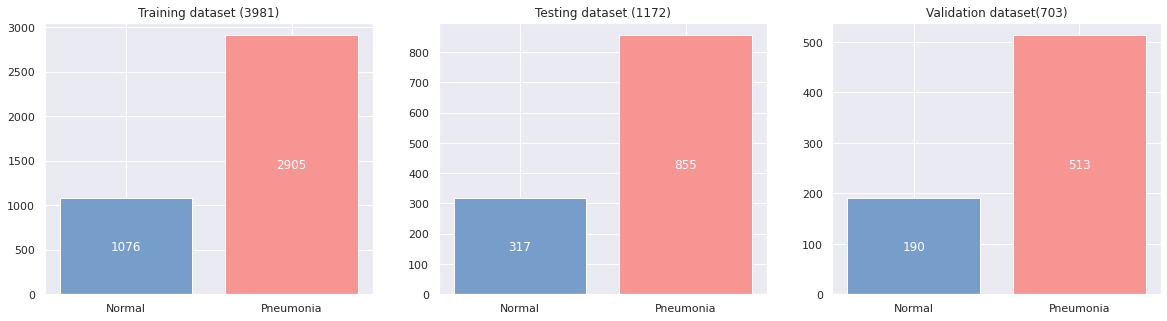

In [147]:
train_n_size = train_normal.shape[0]
train_p_size = train_pneumonia.shape[0]

test_n_size = test_normal.shape[0]
test_p_size = test_pneumonia.shape[0]

val_n_size = val_normal.shape[0]
val_p_size = val_pneumonia.shape[0]

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,5))
p1 = ax1.bar(['Normal', 'Pneumonia'],[train_n_size, train_p_size], color=['#779ECB', '#F69592'])
p2 = ax2.bar(['Normal', 'Pneumonia'],[test_n_size, test_p_size], color=['#779ECB', '#F69592'])
p3 = ax3.bar(['Normal', 'Pneumonia'],[val_n_size, val_p_size], color=['#779ECB', '#F69592'])
ax1.title.set_text('Training dataset (%d)' % ( train_n_size + train_p_size ))
ax2.title.set_text('Testing dataset (%d)' % ( test_n_size + test_p_size ))
ax3.title.set_text('Validation dataset(%d)' % ( val_n_size + val_p_size ))
ax1.bar_label(p1, label_type='center', color="white")
ax2.bar_label(p2, label_type='center', color="white")
ax3.bar_label(p3, label_type='center', color="white")
plt.show()

<h2> Data Preprocessing </h2> <br>
    After loading the resized images, we create our training, testing and validataion datasets along with
    their respective labels. We assign <b>Pneumonia</b> cases with label 0 and <b>Normal</b> cases with label 1. <br>

In [148]:
# train = train[0]
# test = test[0]
# val = val[0]

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

<h2> Image Normalization </h2> <br>
    We normalize pixel values for each image into the range [0-1], in order to reduce the model's complexity and aid with the calculations <br>

In [149]:
# NORMALIZE IMAGE PIXELS VALUES
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# RESIZE DATA FOR DEEP LEARNING
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


<h2> Image Augmentation </h2><br>
    We create an image generator which will create a balanced batch size during each
    Neural Network epoch. The images generated will differ slightly, in order to prevent
    overfitting and combat class imbalance, with the usage of techniques like image flipping, zooming and rotating.

In [150]:
datagen = ImageDataGenerator(
          rotation_range = 30,  # randomly rotate image. val = Degree range for random rotations.
          zoom_range = 0.2, # Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
          width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
          horizontal_flip = True)  # randomly flip images

datagen.fit(x_train)

<h2> Model Layers </h2>
<b>1) Conv2D</b> <br>
    This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.<br>
<b>2) MaxPool2D</b> <br> 
    Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension. <br>
<b>3) Dropout</b> <br>
    The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.<br>
<b>4) Flatten</b> <br>
    Flattens the input. Does not affect the batch size. <br> E.g. (1, 10, 64) => (640)<br>
<b>5) Dense</b> <br>
    Just your regular densely-connected NN layer.<br>
<b>6) Batch Normalization</b><br>
    Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.<br>

In [161]:
epochs = 32

model = Sequential()

model.add(Conv2D(32 , (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64 , (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64 , (3,3), strides = 1, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['binary_accuracy'])
display(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
batch_normalization_28 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
batch_normalization_29 (Batc (None, 50, 50, 64)        256       
_________________________________________________________________
dropout_21 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 25, 25, 64)       

None

<h2> Callback Functions </h2>
A callback is an object that can perform actions at various stages of training. In our case we will use ReduceLROnPlateau, which is a callback that reduces learning rate when a metric has stopped improving and EarlyStopping, which stops the model training when a monitored metric has stopped improving. <br> 

With ReduceLROnPlateau, we monitor the validation binary accuracy of our model and we essentialy reduce the learning rate periodically after a predefined number of epochs has passed in which the accuracy does not seem to improve. 
More specifically, every 2 <b>epochs</b> we reduce the <b>learning rate</b> by 0.2 if the accuracy has not improved. The <b>minimum learning rate</b> we can reach is set to be at 0.0000001.<br>

With EarlyStopping, we also monitor the validation binary accuracy stopping the training process when there is no increase for at least 4 epochs.<br>

In [162]:
callbacks = [
    ReduceLROnPlateau(
        monitor='val_binary_accuracy', #MONITOR ACCURACY 
        factor=0.2,
        verbose = 2,
        patience=2, 
        min_lr=0.0000001
    ),
    EarlyStopping(
        monitor="val_binary_accuracy",
        min_delta=0.02,
        patience=4,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )
]

<h2> Model Training </h2>
In the next cell, we initiate the training of the Convolutional Neural Network, for a number of 32 epochs. We use the Image generator for training and validation data flow, which as discussed earlier, helps with overfitting and class imbalance.

In [163]:
model_var = model.fit(
    datagen.flow(x_train,y_train, batch_size = 32), 
    epochs=epochs, 
    validation_data = datagen.flow(x_val, y_val),
    callbacks = callbacks)

Epoch 1/32
125/125 [==============================] - 25s 191ms/step - loss: 1.3031 - binary_accuracy: 0.7595 - val_loss: 6.3586 - val_binary_accuracy: 0.7297
Epoch 2/32
125/125 [==============================] - 23s 188ms/step - loss: 0.3027 - binary_accuracy: 0.8801 - val_loss: 11.5115 - val_binary_accuracy: 0.7297
Epoch 3/32
125/125 [==============================] - 23s 187ms/step - loss: 0.2757 - binary_accuracy: 0.9001 - val_loss: 12.4921 - val_binary_accuracy: 0.7297

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/32
125/125 [==============================] - 24s 188ms/step - loss: 0.1833 - binary_accuracy: 0.9351 - val_loss: 7.7969 - val_binary_accuracy: 0.7297
Epoch 5/32
125/125 [==============================] - 24s 188ms/step - loss: 0.1551 - binary_accuracy: 0.9431 - val_loss: 0.9529 - val_binary_accuracy: 0.8464
Epoch 6/32
125/125 [==============================] - 23s 187ms/step - loss: 0.1812 - binary_accuracy: 0.9396 - val_loss:

<h2> Model Evaluation & Save</h2>
Below we save our model to a predefined path and perform an evaluation using our testing datasets. The accuracy score seems really good and the loss rational.

In [164]:
model.save(model_save_path+'/chest-xray-temp.h5')
# model = load_model(model_save_path+'/chest-xray.h5')
print("Loss: " , model.evaluate(x_test,y_test)[0])
print("Accuracy: " , model.evaluate(x_test,y_test)[1]*100 , "%")

37/37 [==============================] - 2s 35ms/step - loss: 0.2680 - binary_accuracy: 0.9053
Loss:  0.2680274546146393
37/37 [==============================] - 1s 33ms/step - loss: 0.2680 - binary_accuracy: 0.9053
Accuracy:  90.52901268005371 %


<h2> Display Accuracies & Loss </h2>
    Below we display our model's training and validation accuracies and losses. 

In [167]:
len(train_acc)

12

In [168]:
len(epoch_items)

11

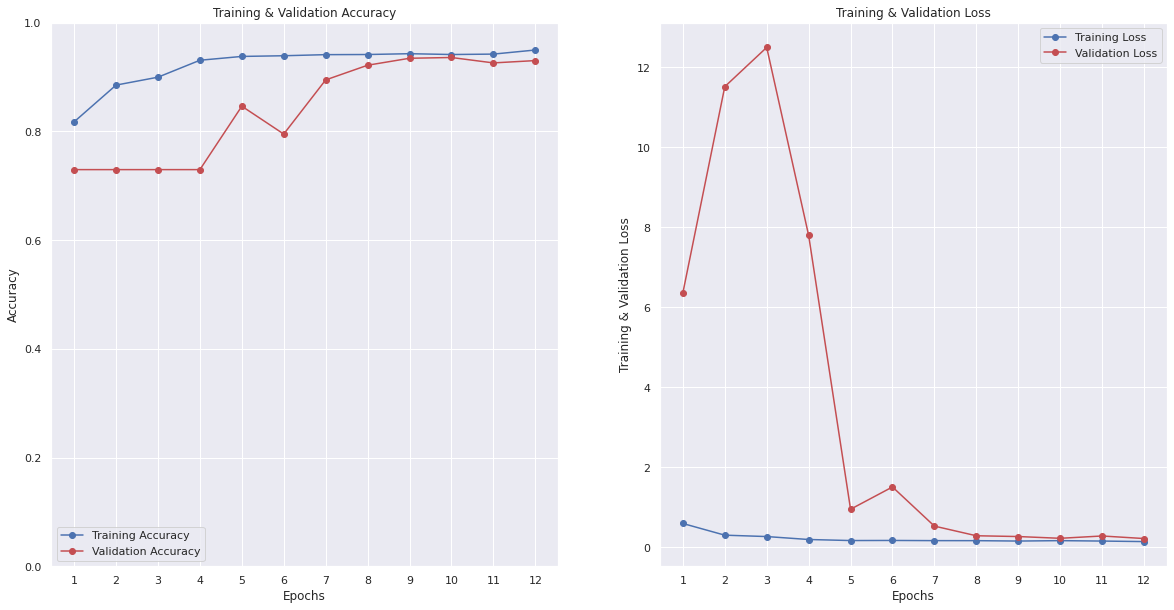

In [170]:

sns.set()
epoch_items = list(range(1,min(epochs+1,len(train_acc)+1)))
fig , ax = plt.subplots(1,2)
train_acc = model_var.history['binary_accuracy'] #accuracy
train_loss = model_var.history['loss']
val_acc = model_var.history['val_binary_accuracy'] # val_accuracy
val_loss = model_var.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epoch_items , train_acc , 'bo-' , label = 'Training Accuracy')
ax[0].plot(epoch_items , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_ylim([0,1])
ax[0].set_xlabel("Epochs")
ax[0].set_xticks(epoch_items)
ax[0].set_ylabel("Accuracy")

ax[1].plot(epoch_items , train_loss , 'b-o' , label = 'Training Loss')
ax[1].plot(epoch_items , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_xticks(epoch_items)
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [171]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

/home/deligianp/D/ubuntu/workspaces/python/Deep_Learning/venv/lib/python3.9/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<h2> Classification Report & Confusion Matrix</h2>
    Following our model's predictions, we illustrate a classification report which demonstrates precision, recall, f1-score and support for each of the two classes as well as a confusion matrix.

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.99      0.88      0.93       855
   Normal (Class 1)       0.75      0.97      0.85       317

           accuracy                           0.91      1172
          macro avg       0.87      0.93      0.89      1172
       weighted avg       0.92      0.91      0.91      1172



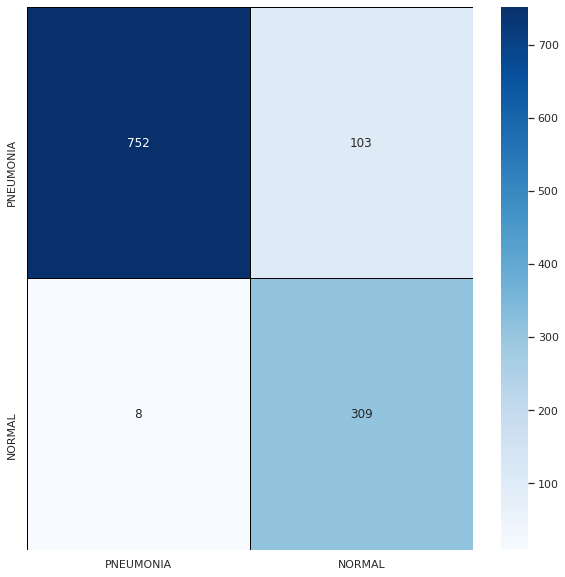

In [172]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize = (10,10))
sns.heatmap(
    cm,cmap= "Blues", 
    linecolor = 'black' , 
    linewidth = 1 , 
    annot = True, 
    fmt='',
    xticklabels = labels,
    yticklabels = labels)
plt.show()

<h2> Prediction Visualizations </h2>
In the following 3 cells we illustrate for visualization purposes some correctly and missclassified X-RAY images.

In [173]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

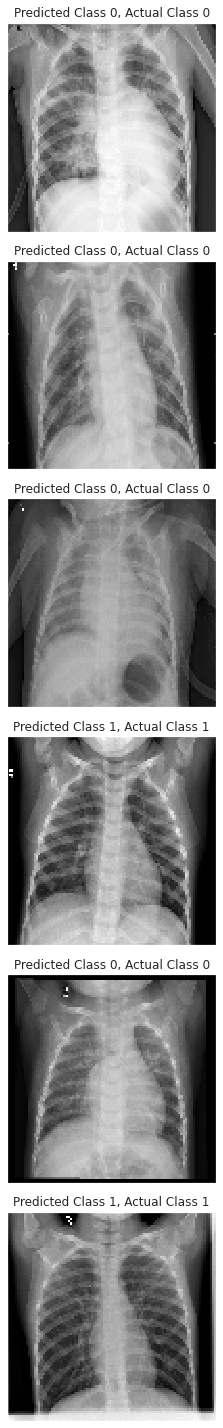

In [174]:
i = 0
sns.set()
plt.figure(figsize=(20,20))
for c in correct[:6]:
    plt.subplot(6,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(img_size,img_size), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

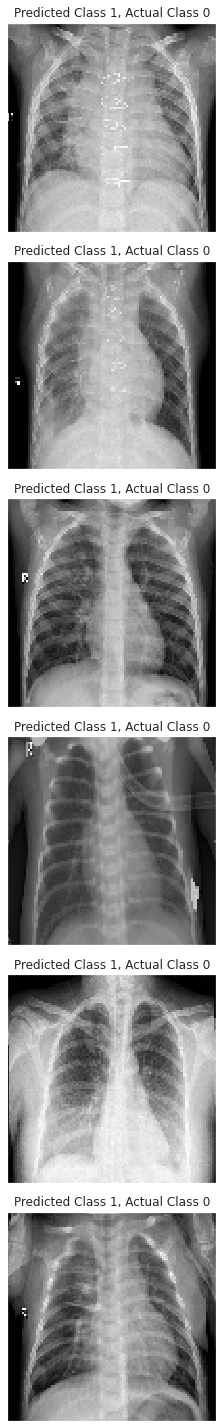

In [175]:
i = 0
sns.set()
plt.figure(figsize=(20,20))
for c in incorrect[:6]:
    plt.subplot(6,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(img_size,img_size), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

<h2> Results & Conclusions </h2>
Overall, we have managed to achieve high accuracies with regards to the training, testing and validation processes.
Initially, our validation accuracy distribution presented some weird flunctuations and was preety low with regards to training accuracy. That draw the conclusion that the model was overfiting and thus we had to identify the cause of it.
We began by experimenting with the distribution of training, testing and validation datasets that were by the repo disproportionately distributed. We concluded in using 68% of the total dataset as a training segment, 20% as a testing and 15% as a validation. The results were astonishingly better than our previous effort achieving close to 90% percent for both training and validation accuracies, eventually leading to the conclusion that the poor pre-defined distribution of the dataset instances to training, testing and validation segments was causing the overfitting and weird validation accuracy flunctuations.